## comp_mean_grid
Compute grid-related variables from time-average data (SSH), including corrections for vertical grid metrics

Namely:
* corrected e3t and e3w
* corrected depth_c_3d and depth_l_3d
* hbot (bottom depth)

This version reads in zarr file with mean grid copied

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from pathlib import Path
import os, time
import numpy as np

import xarray as xr
from xorca.lib import load_xorca_dataset
import itidenatl.gridop as gop
import itidenatl.utils as ut

In [2]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(threads_per_worker=8) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:36913 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 56 Memory: 236.33 GiB


In [3]:
scratch = Path(os.getenv("SCRATCHDIR"))
workdir = Path("/work/CT1/ige2071/nlahaye")

grid_path = scratch #Path("/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-I/")
mean_path = Path("/work/CT1/ige2071/SHARED/mean")

ssh_fname = "global_mean_gridT-2D.zarr"
grid_fname = "eNATL60_rest_grid.zarr"

out_file = scratch/"eNATL60_mean_grid_z.zarr"

grid_file = grid_path/grid_fname

In [35]:
%%time
chk_xy, chk_z = 200, 150
chunks = {dim:chk_xy for dim in ["x_c", "x_r", "y_c", "y_r"]}
chunks.update({dim:chk_z for dim in ["z_c", "z_l"]})

ds_g = xr.open_zarr(grid_file)
ds_g = ds_g.drop_dims(("y_r", "x_r"))\
                .reset_coords(names=("e1t", "e2t"), drop=True)
varnames = [v.name for v in ds_g.data_vars.values() if len(v.dims)>=3]
ds_g = ds_g.set_coords([v.name for v in ds_g.data_vars.values() if len(v.dims)==1])
ds_g = ds_g.set_coords(["tmaskutil", "tmask"])
ds_g = ds_g.get(varnames)

ds_g = ds_g.chunk({d:chunks[d] for d in ds_g.dims})
for k in ds_g:
    print(k, ds_g[k].encoding.pop("chunks", None))
for k in ds_g.coords:
    print(k, ds_g[k].encoding.pop("chunks", None))

ds_g

depth_c_3d (300, 200, 200)
depth_l_3d (300, 200, 200)
e3t (300, 200, 200)
e3w (300, 200, 200)
tmask (300, 200, 200)
depth_c (300,)
depth_l (300,)
tmaskutil (200, 200)
x_c (8354,)
y_c (4729,)
z_c (300,)
z_l (300,)
CPU times: user 245 ms, sys: 73.7 ms, total: 318 ms
Wall time: 948 ms


<xarray.Dataset>
Dimensions:     (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    depth_c     (z_c) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c         (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    depth_c_3d  (z_c, y_c, x_c) float32 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
Attributes:
    TimeStamp:  13/07/2018 22:32:53 +0200
    file_name:  mesh_mask.nc

### create zarr archive and copy targeted data
Warning, this will not store coordinates (except dimension coordinates). Storing coordinates will be done as a second step

In [24]:
%%time
### open zarr archive. this may take a minute or so
ds_g.to_zarr(out_file, mode="w", compute=False, consolidated=True)

CPU times: user 1.1 s, sys: 102 ms, total: 1.2 s
Wall time: 2.87 s


Delayed('_finalize_store-6789d316-7878-4d16-bf2f-437264b21f96')

In [39]:
%%time
### write coordinates
ds_g.drop([v for v in ds_g.data_vars]).to_zarr(out_file, mode="a", compute=True)

CPU times: user 15.3 s, sys: 1.24 s, total: 16.6 s
Wall time: 49.2 s


In [7]:
def dist_write(ds, varname, store_dir, dim="y"):
    """ utilitary function that loops over a dimension chunk to store in a zarr archive """
    sds = ds.get([varname])
    dim = next(di for di in sds.dims if di.startswith(dim))
    co_vir = [co for co in sds.coords]
    sds = sds.drop([co for co in sds.coords])
    chk_z = np.r_[0, np.array(sds.chunks[dim]).cumsum()]
    print("now doing {} chunk (.../{}):".format(dim,chk_z.size-1), end=" ")
    for iz in range(chk_z.size-1):
        print(iz, end=", ")
        sliz = slice(chk_z[iz], chk_z[iz+1])
        sds.isel({dim:sliz}).to_zarr(store_dir, mode="a", region={dim:sliz})
    return sds

## load SSH, compute hbot and store
this will also store the coordinates

In [43]:
dims = {"ssh": ("x_c", "y_c"), "temp":("x_c", "y_c", "z_c"), "salt":("x_c", "y_c", "z_c")}
dimap = {"x":"x_c", "y":"y_c", "deptht":"z_c"}
chk_tot = ds_g.chunks

def get_var(path, varname):
    da = xr.open_zarr(path)[varname].squeeze()
    da = da.rename({dim:dimap[dim] for dim in da.dims})
    da = da.chunk({dim:chk_tot[dim] for dim in da.dims})
    return da

ds_g["sossheig"] = get_var(mean_path/ssh_fname, "sossheig").persist()

ds_g.sossheig.encoding.pop("chunks") # otherwise writing zarr raise error

ds_g

<xarray.Dataset>
Dimensions:     (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c         (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    depth_c     (z_c) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(150,), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    depth_c_3d  (z_c, y_c, x_c) float32 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(150, 200, 200), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
Attributes:
    TimeStamp:  13/07/2018 22:32:53 +0200
    file_name:  mesh_mask.nc

In [41]:
%%time
### compute hbot
ds_g["hbot"] = gop.get_hbot(ds_g, overwrite=True).where(ds_g.tmaskutil).persist() #ds_re.e3t.where(ds_re.tmask).sum("z_c").persist() #
#ds_re

CPU times: user 1.52 s, sys: 19 ms, total: 1.53 s
Wall time: 1.51 s


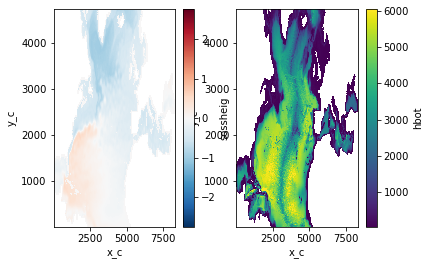

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
ds_g.sossheig.plot(ax=axs[0])
ds_g.hbot.plot(ax=axs[1])
for ax in axs:
    ax.set_aspect(1)

In [46]:
%%time
### store result for SSH and HBOT. This will store the coordinates as well
ds_g.get(["sossheig", "hbot"]).to_zarr(out_file, mode="a")

CPU times: user 12.4 s, sys: 991 ms, total: 13.4 s
Wall time: 45.1 s


## compute corrected grid (depth and metrics) and store
reading from zarr : very fast

In [40]:
varnames = [v for v in ds_g.data_vars]
print(varnames)

['depth_c_3d', 'depth_l_3d', 'e3t', 'e3w']


In [47]:
%%time
# compute correction for e3t and e3w
# cf gridop.get_rec_e3z
    
lacorr = (1. + ds_g.sossheig / ds_g.hbot).where(ds_g.tmaskutil).persist()

### compute corrected vertical grid metrics and store in zarr
for v in ["e3t", "e3w"]:
    (ds_g.get([v]) * lacorr).to_zarr(out_file, mode="a")
    print(v, "done")

CPU times: user 1min 3s, sys: 4.28 s, total: 1min 7s
Wall time: 2min 29s


In [64]:
%%time
### compute corrected 3D depth grids
for v in ["depth_c_3d", "depth_l_3d"]:
    (ds_g.get([v]) * lacorr + ds_g.sossheig).to_zarr(out_file, mode="a")
    print(v, "done")

depth_c_3d done
depth_l_3d done
CPU times: user 53.4 s, sys: 3.58 s, total: 56.9 s
Wall time: 1min 52s


In [ ]:
### check result
jy = 4000
ds_re = xr.open_zarr(out_file)
fig, axs = plt.subplots(2, len(varnames))
for i,v in enumerate(varnames):
    dimz = next(d for d in ds_re[v].dims if d.startswith("z"))
    ds_re[v].isel({"y_c":jy, dimz:0}).plot(ax=axs[0,i])
    ds_re[v].isel({"y_c":jy}).plot(ax=axs[1,i])

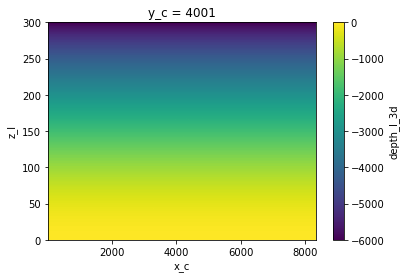

In [60]:
ds_g.depth_l_3d.isel(y_c=4000).plot()

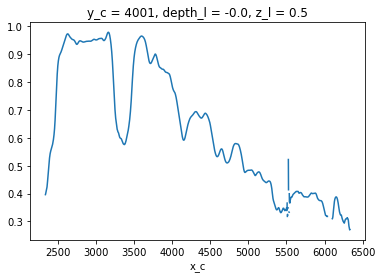

In [58]:
(ds_g.depth_l_3d * lacorr + ds_g.sossheig).isel(y_c=4000, z_l=0).plot()

## post processing
rechunk

In [4]:
ds_re = xr.open_zarr(out_file)
chk_xy, chk_z = 200, 10
new_chks = {d:chk_z for d in ds_re.dims if d.startswith("z")}
new_chks.update({d:chk_xy for d in ["x_c","y_c"]})
ds_re = ds_re.chunk(new_chks)

### remove encoding "chunks" to write with zarr
for k in ds_re.coords.values():
    print(k.name, k.encoding.pop("chunks", None))
for k in ds_re.data_vars.values():
    print(k.name, k.encoding.pop("chunks", None))
    
ds_re

depth_c (150,)
depth_l (150,)
x_c (8354,)
y_c (4729,)
z_c (300,)
z_l (300,)
depth_c_3d (150, 200, 200)
depth_l_3d (150, 200, 200)
e3t (150, 200, 200)
e3w (150, 200, 200)
hbot (200, 200)
sossheig (200, 200)
tmask (150, 200, 200)
tmaskutil (200, 200)


<xarray.Dataset>
Dimensions:     (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
    depth_c     (z_c) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(10,), meta=np.ndarray>
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c         (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    depth_c_3d  (z_c, y_c, x_c) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>

In [5]:
out_new = out_file.parent/(out_file.stem+"_cz10.zarr")
out_new

PosixPath('/scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z_cz10.zarr')

In [10]:
client.restart()

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Client Scheduler: tcp://127.0.0.1:34619 Dashboard: http://127.0.0.1:46806/status,Cluster Workers: 7 Cores: 56 Memory: 236.33 GiB


In [6]:
%%time
ds_re.to_zarr(out_new, mode="w", compute=False, consolidated=True)

CPU times: user 18.5 s, sys: 660 ms, total: 19.2 s
Wall time: 19 s


Delayed('_finalize_store-943afa93-b8c8-48f6-b1d8-ca7045cff0e7')

In [7]:
%%time
ds_re.get([v for v in ds_re.data_vars if len(ds_re[v].dims)<3]).to_zarr(out_new, mode="a")

CPU times: user 5.29 s, sys: 423 ms, total: 5.72 s
Wall time: 8.27 s


In [8]:
%%time
les_var = [v for v in ds_re.data_vars if len(ds_re[v].dims)>=3]
print("copying")
for v in les_var:
    ds_re.get([v]).to_zarr(out_new, mode="a")
    print(v, end=", ")
print("done")

copying
v, v, 

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


v, 

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


v, v, done
CPU times: user 6min, sys: 18.5 s, total: 6min 19s
Wall time: 8min 46s


## Old cells / Old stuff

In [34]:
%%time
### store variables that do not need modification, or need some computation
var_raw = ["tmask"]
sds = ds_new.get(var_raw)#.isel(z_c=slice(0,10))
sds.to_zarr(workdir/"prov.zarr", mode="w")

CPU times: user 8min 49s, sys: 14.8 s, total: 9min 3s
Wall time: 9min 6s


In [24]:
chk_z = np.r_[0, np.array(ds_new.chunks["z_c"]).cumsum()]
chk_z

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300])

In [33]:
%%time

sds = ds_new.get(["tmask"])
co_vir = [co for co in sds.coords]# if "z_c" not in sds.coords[co].dims]
sds = sds.drop(co_vir)

print("now doing chunk (/{}):".format(chk_z.size-1), end=" ")
for iz in range(chk_z.size-1):
    print(iz, end=", ")
    sliz = slice(chk_z[iz], chk_z[iz+1])
    sds.isel(z_c=sliz).to_zarr(workdir/"prov.zarr", mode="a", region={"z_c":sliz})
print("done")

now doing chunk (/30): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, done
CPU times: user 4min 55s, sys: 19.7 s, total: 5min 15s
Wall time: 7min 12s
